<a href="https://colab.research.google.com/github/ananyasingh7/deep-learning-projects/blob/main/xbd_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
from fastai.vision.all import *

Download Link: https://xview2.org/download-links

Context: The xBD dataset contains high-resolution satellite imagery (from DigitalGlobe) before and after natural disasters (e.g., hurricanes, floods, wildfires). It includes 22,837 images with annotations for building damage assessment, categorized into four classes: no damage, minor damage, major damage, and destroyed.

Objective: The objectives with the xBD dataset, as outlined by the xView2 challenge and its application in building damage assessment, are:

Image Classification: Classify the level of building damage (no damage, minor damage, major damage, destroyed) using pre- and post-disaster satellite imagery.
Semantic Segmentation: Label pixels in the images to identify damaged or undamaged building areas, providing a detailed spatial analysis of damage.
Disaster Response Support: Develop models to assist in real-world disaster response by quickly assessing building damage from satellite imagery, aiding in resource allocation and recovery planning.
Change Detection: Leverage paired pre- and post-disaster images to detect and quantify changes, enhancing understanding of disaster impact.

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
path = Path('/content/drive/MyDrive/train')
path.ls()

(#3) [Path('/content/drive/MyDrive/train/targets'),Path('/content/drive/MyDrive/train/images'),Path('/content/drive/MyDrive/train/labels')]

In [110]:
import json
with open(path/'labels/hurricane-florence_00000008_post_disaster.json') as f:
  label = json.load(f)
  print(label)

{'features': {'lng_lat': [{'properties': {'feature_type': 'building', 'subtype': 'no-damage', 'uid': '8eec269c-c255-4609-bbf1-a1ca853392c7'}, 'wkt': 'POLYGON ((-79.04517326964154 33.65414078708363, -79.0450961525891 33.65420736495534, -79.0450120428567 33.65413823452042, -79.04517326964154 33.65414078708363))'}, {'properties': {'feature_type': 'building', 'subtype': 'no-damage', 'uid': '01e702f5-4454-418a-8a99-3350e4738b4e'}, 'wkt': 'POLYGON ((-79.04492956583383 33.65413692873359, -79.04505996335628 33.65424116148623, -79.04503338620999 33.65425612280388, -79.0450190864685 33.65427253679971, -79.04499216419896 33.65428986045596, -79.04499509050451 33.65430710163378, -79.04494988598704 33.65433960220847, -79.04475819075415 33.65419524957913, -79.04483022813052 33.65413535600628, -79.04492956583383 33.65413692873359))'}, {'properties': {'feature_type': 'building', 'subtype': 'no-damage', 'uid': 'd93dcc8d-61bd-4671-bf6a-d2ed62d08079'}, 'wkt': 'POLYGON ((-79.04491751686103 33.6543736889284

In [111]:
'''
Images folder: satellite images captured before and after natural disasters
Labels folder: JSON files containing annotations for building damage assessment
Target folder: serves as the root directory for setting up the DataBlock or DataLoaders to organize and load your dataset effecifiently for training a model
'''

'\nImages folder: satellite images captured before and after natural disasters\nLabels folder: JSON files containing annotations for building damage assessment\nTarget folder: serves as the root directory for setting up the DataBlock or DataLoaders to organize and load your dataset effecifiently for training a model\n'

In [112]:
'''
Image Classification: Classify the level of building damage (no damage, minor damage, major damage, destroyed) using pre- and post-disaster satellite imagery.
'''

'\nImage Classification: Classify the level of building damage (no damage, minor damage, major damage, destroyed) using pre- and post-disaster satellite imagery.\n'

In [113]:
import os
import json
from pathlib import Path

image_to_subtypes = {}
path_labels = Path(path/'labels')
for json_file in path_labels.glob('*.json'):
    with open(json_file, 'r') as f:
        data = json.load(f)
        image_name = data['metadata']['img_name']
        subtypes = []
        for feature in data['features']['lng_lat']:  # or 'xy' depending on your preference
            if 'subtype' not in feature['properties']:
                continue
            subtypes.append(feature['properties']['subtype'])
        if subtypes:  # Only add if subtypes are not empty
            image_to_subtypes[image_name] = subtypes

# Optional: Print the dictionary to verify
# print(image_to_subtypes['socal-fire_00000468_post_disaster.png'])

In [114]:
print(len(image_to_subtypes))

2283


In [115]:
severity = {
    'no-damage': 0,
    'minor-damage': 1,
    'major-damage': 2,
    'destroyed': 3,
    'un-classified': -1  # Treat as special/low priority
}

In [116]:
image_to_label = {}
for image, subtypes_list in image_to_subtypes.items():
    counts = Counter(subtypes_list) # ex:
    if not counts:
        continue
    # Find the max count
    max_count = max(counts.values())
    # Get candidates with max count
    candidates = [subtype for subtype, count in counts.items() if count == max_count]
    # If tie, choose the one with highest severity
    if len(candidates) > 1:
        best_label = max(candidates, key=lambda s: severity.get(s, -1))
    else:
        best_label = candidates[0]
    image_to_label[image] = best_label

#example:
print(image_to_label['socal-fire_00000468_post_disaster.png'], image_to_label['hurricane-matthew_00000307_post_disaster.png'])

no-damage minor-damage


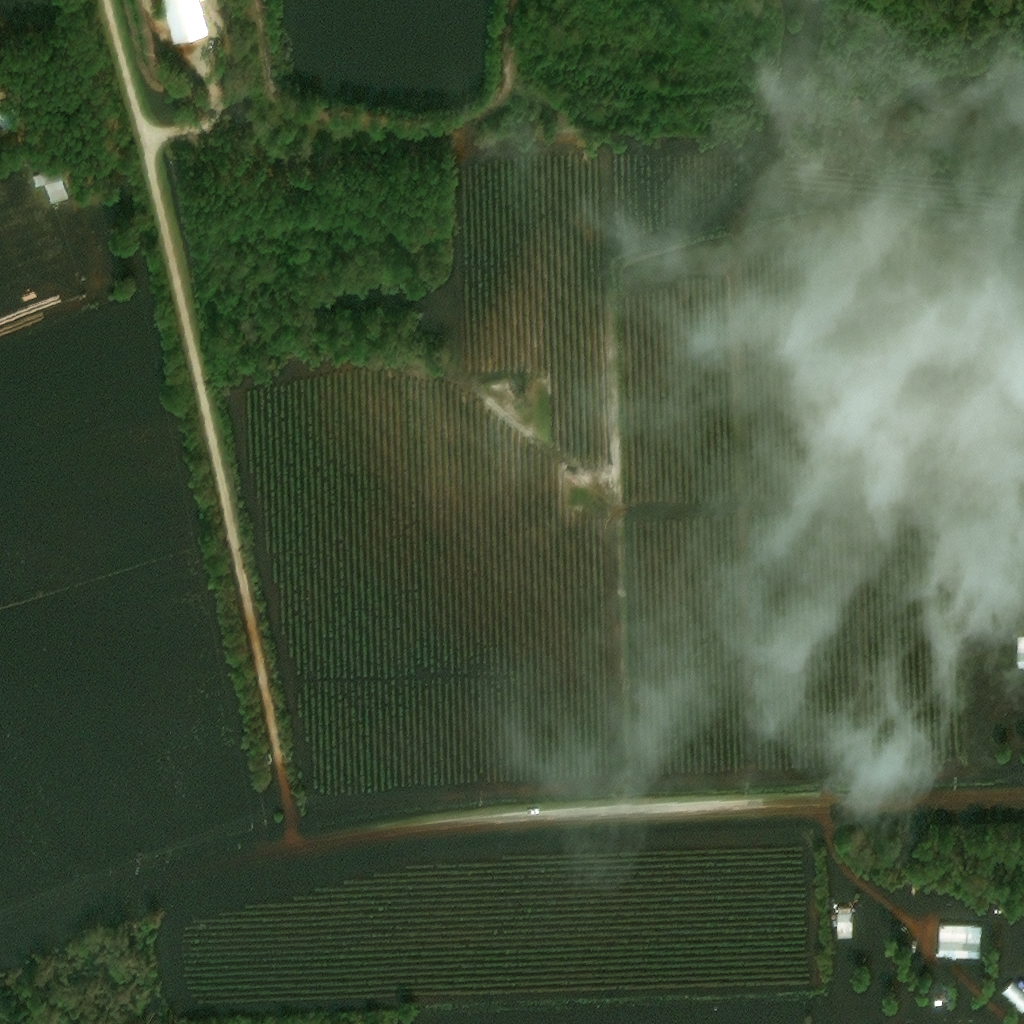

In [117]:
from PIL import Image
display(Image.open(path/'images/hurricane-florence_00000086_post_disaster.png'))

In [124]:
path_images = Path(path/'images')
all_images = get_image_files(path_images)
post_images = [x for x in all_images if 'post' in x.name]
print(f"All images: {all_images}")
print(f"Post-disaster images: {post_images}")
print(f"image_to_label keys: {list(image_to_label.keys())}")
items = [x for x in post_images if x.name in image_to_label]
print(f"Selected items: {items}")
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda o: items,
    get_y=lambda x: image_to_label.get(x.name, 'unknown'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224)
)

All images: [Path('/content/drive/MyDrive/train/images/hurricane-florence_00000018_post_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-florence_00000086_post_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-florence_00000102_pre_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-florence_00000403_pre_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-florence_00000405_post_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-florence_00000504_pre_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-harvey_00000000_post_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-harvey_00000015_pre_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-harvey_00000134_post_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-harvey_00000216_pre_disaster.png'), Path('/content/drive/MyDrive/train/images/hurricane-harvey_00000228_pre_disaster.png'), Pa

In [125]:
dls = dblock.dataloaders(path, bs=64)

In [126]:
dls.show_batch(max_n=9, figsize=(7,7))

ValueError: This DataLoader does not contain any batches